In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from IPython.display import display, Image

In [2]:
#讀取券商匯出的交易紀錄
df = pd.read_csv('./data/m07.csv', encoding='cp950')

In [3]:
#去取券商輸出格式中不必要的符號
df.columns = df.columns.str.strip()
for c in df.columns:
    if df[c].dtypes != 'int' and df[c].dtypes != 'float':
        df[c] = df[c].astype('str').str.strip()

In [4]:
#型態處理
for c in ['口數','成交價','成交收付']:
    df[c] = df[c].astype('int32')
df['成交日期'] = pd.to_datetime(df.成交日期)

In [5]:
#重新以交易時間排序
df.sort_values('成交日期', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(1)

成交日期 買賣別    商品名稱  口數    成交價 手續費 交易稅  成交收付  倉別   幣別
0 2020-07-02 08:59:00  買進  小型台指07   1  11603  25  12     0  新倉  新台幣

In [6]:
#建立分析交易紀錄需要用到的額外欄位
df['部位數'] = df.apply(lambda row: (1 if row['買賣別'] == "買進" else -1)*row['口數'], axis=1)
df['交易紀錄'] = df.apply(lambda row:row['倉別']+row['買賣別']+str(row['口數']), axis=1)
df.成交日期 =df.成交日期.dt.floor('Min')

In [7]:
df.dtypes

成交日期    datetime64[ns]
買賣別             object
商品名稱            object
口數               int32
成交價              int32
手續費             object
交易稅             object
成交收付             int32
倉別              object
幣別              object
部位數              int64
交易紀錄            object
dtype: object

In [8]:
#以1分K整併所有交易資料
df_summary = df.groupby(['成交日期']).agg({
    '口數':'sum',
    '成交價':'mean',
    '成交收付':'sum',
    '倉別':'unique',
    '買賣別':'unique',
    '交易紀錄':list,
    '部位數':'sum'}).reset_index()
df_summary = df_summary.sort_values('成交日期')
df_summary.columns = ['成交日期','口數','成交價','成交收付','倉別','買賣別','交易紀錄','部位數']
df_summary['成交日'] = df_summary.成交日期.dt.date
df_summary['淨部位'] = df_summary.groupby('成交日')['部位數'].cumsum()

In [9]:
df_summary.head(1)

成交日期  口數      成交價  成交收付    倉別   買賣別     交易紀錄  部位數         成交日  淨部位
0 2020-07-02 08:59:00   1  11603.0     0  [新倉]  [買進]  [新倉買進1]    1  2020-07-02    1

In [10]:
#輸出成 multicharts 進出場訊號，便可顯示在圖中
one_minute = datetime.timedelta(minutes=1)
with open('./output/transaction.txt', "w") as f:
    prevRecordDate = ""; currentDate = ""
    for idx, row in df_summary.iterrows():
        mc_thisbar = row['成交日期']+one_minute
        currentDate = "{}{:02d}{:02d}".format(mc_thisbar.date().year - 1900, 
                      mc_thisbar.date().month,
                      mc_thisbar.date().day)
        
        #如果有留倉，在1345平掉，僅作紀錄
        if prevRecordDate != "" and prevRecordDate != currentDate:
            f.write("if date = {} then setexitonclose;".format(prevRecordDate) + '\n')
        
        #從交易紀錄產生進場限制
        entry_cond_str = "if date = {}{:02d}{:02d} and time = {:02d}{:02d} then " \
              .format(mc_thisbar.date().year - 1900, 
                      mc_thisbar.date().month,
                      mc_thisbar.date().day,
                      mc_thisbar.time().hour,
                      mc_thisbar.time().minute)
        #從交易紀錄產生出場限制
        exit_cond_str = "if date = {}{:02d}{:02d} and time = {:02d}{:02d} and marketposition(0) <> 0 then " \
              .format(mc_thisbar.date().year - 1900, 
                      mc_thisbar.date().month,
                      mc_thisbar.date().day,
                      mc_thisbar.time().hour,
                      mc_thisbar.time().minute)
        
        pos_size = row['口數']; price = row['成交價']
        entry_str = ""; exit_str = ""
    
        is_profit = row['成交收付'] >= 0      
        n_trans_type = len(row['倉別'])
        
        #加上交易方向及部位大小
        if n_trans_type == 1 and row['倉別'][0] == '新倉':
            if row['成交收付'] == 0:
                if row['買賣別'][0] == "買進":
                    entry_str = "{} {} contract this bar at close;".format('buy', pos_size)
                else:
                    entry_str = "{} {} contract this bar at close;".format('sellshort', pos_size)
            else: #某券商的特殊現象，帶有損益的新倉，實際應視為平倉
                if row['買賣別'][0] == "買進":
                    exit_str = '{} {} contract total this bar at close;'.format('buytocover', pos_size)
                else:
                    exit_str = '{} {} contract total this bar at close;'.format('sell', pos_size)       
        if n_trans_type == 1 and row['倉別'][0] == '平倉':
            if row['買賣別'][0] == "買進":
                exit_str = '{} {} contract total this bar at close;'.format('buytocover', pos_size)
            else:
                exit_str = '{} {} contract total this bar at close;'.format('sell', pos_size)
        
        #單根K棒進出的部位整併
        if n_trans_type > 1 and row['部位數'] != 0:
            if row['買賣別'][0] == "買進":
                if row['淨部位'] > 0:
                    #反手翻成淨部位數
                    entry_str = "{} {} contract this bar at close;".format('buy', abs(row['淨部位']))
                else:
                    #淨部位尚未翻正，所以是空單調節
                    exit_str = '{} {} contract total this bar at close;'.format('buytocover', abs(row['部位數']))
            else:
                if row['淨部位'] < 0:
                    #反手翻成淨部位數
                    entry_str = "{} {} contract this bar at close;".format('sellshort', abs(row['淨部位']))
                else:
                    #淨部位尚未翻正，所以是多單調節
                    exit_str = '{} {} contract total this bar at close;'.format('sell', abs(row['部位數']))
        
        if len(entry_str) > 0:
            f.write(entry_cond_str + entry_str+'\n')
        if len(exit_str) > 0:
            f.write(exit_cond_str + exit_str + '\n')
        prevRecordDate = "{}{:02d}{:02d}".format(mc_thisbar.date().year - 1900, 
                      mc_thisbar.date().month,
                      mc_thisbar.date().day)

In [11]:
#查詢特定一天交易紀錄
df_summary.query('成交日期 >= "2020-08-07" and 成交日期 <= "2020-08-08"')

成交日期  口數      成交價  成交收付        倉別       買賣別                   交易紀錄  部位數         成交日  淨部位
460 2020-08-07 09:08:00   1  12817.0     0      [新倉]      [賣出]                [新倉賣出1]   -1  2020-08-07   -1
461 2020-08-07 09:12:00   1  12815.0   100      [平倉]      [買進]                [平倉買進1]    1  2020-08-07    0
462 2020-08-07 09:16:00   1  12829.0     0      [新倉]      [賣出]                [新倉賣出1]   -1  2020-08-07   -1
463 2020-08-07 09:21:00   2  12815.0     0      [新倉]      [賣出]                [新倉賣出2]   -2  2020-08-07   -3
464 2020-08-07 09:22:00   2  12824.0  -200      [平倉]      [買進]                [平倉買進2]    2  2020-08-07   -1
465 2020-08-07 09:25:00   5  12811.0     0      [新倉]      [賣出]         [新倉賣出3, 新倉賣出2]   -5  2020-08-07   -6
466 2020-08-07 09:26:00   5  12811.0   350      [平倉]      [買進]  [平倉買進1, 平倉買進2, 平倉買進2]    5  2020-08-07   -1
467 2020-08-07 09:34:00   1  12798.0     0      [新倉]      [賣出]                [新倉賣出1]   -1  2020-08-07   -2
468 2020-08-07 09:41:00   1  12795.0   800      [平倉]      [買進]                [平倉買進1]    1  2020-08-07   -1
469 2020-08-07 09:43:00   1  12788.0     0      [新倉]      [賣出]                [新倉賣出1]   -1  2020-08-07   -2
470 2020-08-07 09:44:00   2  12792.0   150  [新倉, 平倉]  [賣出, 買進]         [新倉賣出1, 平倉買進1]    0  2020-08-07   -2
471 2020-08-07 09:45:00   3  12801.0 -1250  [平倉, 新倉]      [買進]  [平倉買進1, 平倉買進1, 新倉買進1]    3  2020-08-07    1
472 2020-08-07 09:48:00   1  12803.0   100      [平倉]      [賣出]                [平倉賣出1]   -1  2020-08-07    0
473 2020-08-07 09:50:00   1  12804.0     0      [新倉]      [賣出]                [新倉賣出1]   -1  2020-08-07   -1
474 2020-08-07 09:57:00   2  12799.0     0      [新倉]      [賣出]                [新倉賣出2]   -2  2020-08-07   -3
475 2020-08-07 10:02:00   1  12796.0   400      [平倉]      [買進]                [平倉買進1]    1  2020-08-07   -2
476 2020-08-07 10:06:00   1  12796.0   150      [平倉]      [買進]                [平倉買進1]    1  2020-08-07   -1
477 2020-08-07 10:10:00   1  12785.0     0      [新倉]      [賣出]                [新倉賣出1]   -1  2020-08-07   -2
478 2020-08-07 10:19:00   1  12756.0     0      [新倉]      [賣出]                [新倉賣出1]   -1  2020-08-07   -3
479 2020-08-07 10:23:00   1  12761.0  1900      [平倉]      [買進]                [平倉買進1]    1  2020-08-07   -2
480 2020-08-07 10:47:00   3  12727.0     0      [新倉]      [賣出]                [新倉賣出3]   -3  2020-08-07   -5
481 2020-08-07 10:49:00   5  12735.0  2350      [平倉]      [買進]                [平倉買進5]    5  2020-08-07    0
482 2020-08-07 11:04:00   1  12748.0     0      [新倉]      [賣出]                [新倉賣出1]   -1  2020-08-07   -1
483 2020-08-07 11:09:00   1  12743.0     0      [新倉]      [賣出]                [新倉賣出1]   -1  2020-08-07   -2
484 2020-08-07 11:14:00   1  12733.0   750      [平倉]      [買進]                [平倉買進1]    1  2020-08-07   -1
485 2020-08-07 11:36:00   1  12723.0     0      [新倉]      [賣出]                [新倉賣出1]   -1  2020-08-07   -2
486 2020-08-07 11:41:00   1  12712.0  1550      [平倉]      [買進]                [平倉買進1]    1  2020-08-07   -1
487 2020-08-07 11:45:00   1  12732.0  -450      [平倉]      [買進]                [平倉買進1]    1  2020-08-07    0
488 2020-08-07 13:00:00   1  12742.0     0      [新倉]      [賣出]                [新倉賣出1]   -1  2020-08-07   -1
489 2020-08-07 13:01:00   1  12738.0     0      [新倉]      [賣出]                [新倉賣出1]   -1  2020-08-07   -2
490 2020-08-07 13:06:00   1  12741.0     0      [新倉]      [賣出]                [新倉賣出1]   -1  2020-08-07   -3
491 2020-08-07 13:10:00   2  12739.0   100      [平倉]      [買進]         [平倉買進1, 平倉買進1]    2  2020-08-07   -1
492 2020-08-07 13:26:00   1  12744.0  -150      [平倉]      [買進]                [平倉買進1]    1  2020-08-07    0

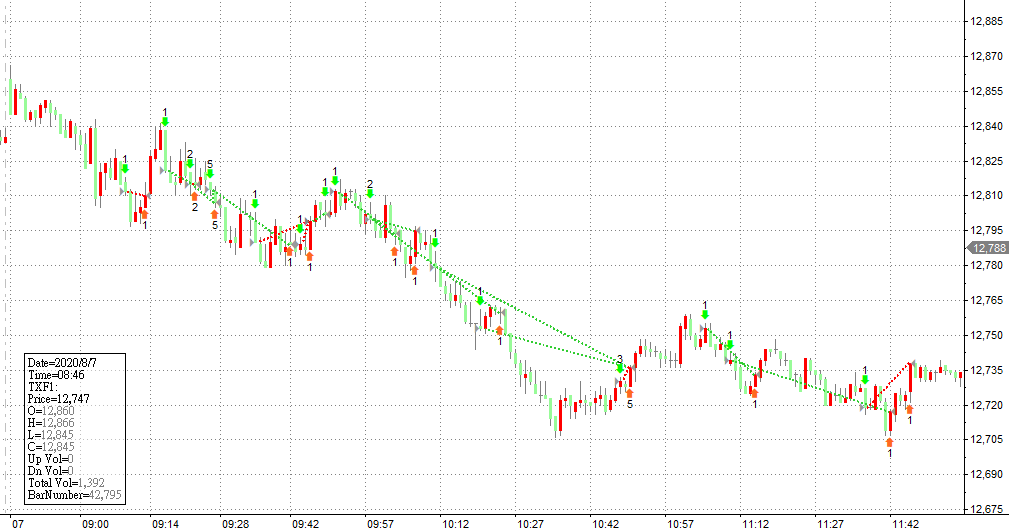

In [12]:
#將 output/transaction.txt 以 multicharts powerlanguage enditor 執行
display(Image(filename='img/mc_demo.png'))